In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import itertools, operator, random, math
from scipy.sparse.linalg import spsolve_triangular
from sklearn import linear_model
import utils as ut
import pandas as pd
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [3]:
def rym(t, pop):
    L, S= pop
    ktrsc, kdeA, kpolyA, kdgrd = 1, 0.5, 0.5, 0.2
    AdeA, ApolyA, Adgrd = 0.8, 0.8, 0.5
    pdeA, ppolyA, pdgrd = 6, 18, 0


    Ktrsc = ktrsc
    KdeA = kdeA*(1+AdeA*(np.cos(2*np.pi*((t - pdeA)%24)/24)))
    KpolyA = kpolyA*(1+ApolyA*(np.cos(2*np.pi*((t - ppolyA)%24)/24)))
    Kdgrd = kdgrd*(1+Adgrd*(np.cos(2*np.pi*((t - pdgrd) %24)/24)))

    dL = Ktrsc - KdeA*L + KpolyA*S
    dS = KdeA*L - KpolyA*S - Kdgrd*S

    dpop = np.array([dL, dS])
    return dpop

In [5]:
dt, pts = 0.01, int(120/0.01)
tspan = np.linspace(dt, 240, num=pts)
pop0 = [1,5]
pop1 = [20,6]
pop2 = [3, 10]
pop3 = [0.1, 10]
pop4 = [10, 0.5]

sol1 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop0, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol1 = rym(sol1.t, sol1.y)

sol2 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop1, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol2 = rym(sol2.t, sol2.y)

sol3 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop2, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol3 = rym(sol3.t, sol3.y)

sol4 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop3, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol4 = rym(sol4.t, sol4.y)

sol5 = integrate.solve_ivp(rym, t_span=[tspan[0], tspan[-1]], y0=pop4, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dsol5 = rym(sol5.t, sol5.y)

In [5]:
# dpop_data_std = np.hstack([dsol1[:, 100:], dsol2[:, 100:]])

In [6]:
pop_data_std = np.hstack([sol1.y[:,100:], sol2.y[:,100:], sol3.y[:,100:], sol4.y[:,100:], sol5.y[:,100:]])
dpop_data_std = np.hstack([rym(sol1.t, sol1.y)[:,100:], rym(sol2.t, sol2.y)[:,100:], rym(sol3.t, sol3.y)[:,100:], rym(sol4.t, sol4.y)[:,100:], rym(sol5.t, sol5.y)[:,100:]])

In [7]:
dpop1 = ut.time_different(dt,dsol1, sol1.y)
dpop2 = ut.time_different(dt,dsol2, sol2.y)
dpop3 = ut.time_different(dt,dsol3, sol3.y)
dpop4 = ut.time_different(dt,dsol4, sol4.y)
dpop5 = ut.time_different(dt,dsol5, sol5.y)
# dpop_data = np.hstack([dpop1, dpop2, dpop3,dpop4, dpop5])

In [8]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [9]:
dpop_diff1 = []
pop_data1 = sol1.y + np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data1 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data1 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
# pop_data1 -= 2*np.random.rand(sol1.y.shape[0], sol1.y.shape[1])
# pop_data1 -= 1*np.random.rand(sol1.y.shape[0], sol1.y.shape[1])
for i, x in enumerate(pop_data1):
    A = matlab.double(list(x))
    data_test = eng.TVRegDiff(A,20,1e-3, [], 'small', 1e-6, dt*0.01, 1, 1)
    dpop_diff1.append(data_test[1:])
dpop_diff1 = np.reshape(dpop_diff1, (dpop1.shape[0], dpop1.shape[1]))
dpop_diff1 *= 0.01

pop_new1 = []
for i in range(2):
    tmp = (np.cumsum(dpop_diff1[i])*dt)
    tmp += np.mean(pop_data1[i]) - np.mean(tmp) 
    pop_new1.append(tmp[100:])
pop_new1 = np.reshape(np.array(pop_new1), (pop_data1.shape[0], pop_data1.shape[1]-100))

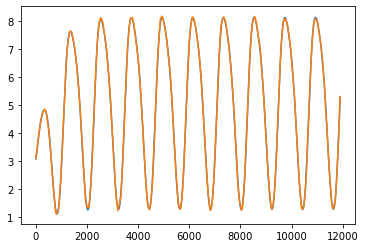

In [41]:
plt.plot(sol1.y[1][100:])
plt.plot(pop_new1[1])

In [10]:
dpop_diff2 = []
pop_data2 = sol2.y + np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data2 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data2 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
for i, x in enumerate(pop_data2):
    A = matlab.double(list(x))
    data_test = eng.TVRegDiff(A,20,1e-3, [], 'small', 1e-6, dt*0.01, 1, 1)
    dpop_diff2.append(data_test[1:])
dpop_diff2 = np.reshape(dpop_diff2, (dpop1.shape[0], dpop1.shape[1]))
dpop_diff2 *= 0.01

pop_new2 = []
for i in range(2):
    tmp = (np.cumsum(dpop_diff2[i])*dt)
    tmp += np.mean(pop_data2[i]) - np.mean(tmp) 
    pop_new2.append(tmp[100:])
pop_new2 = np.reshape(np.array(pop_new2), (pop_data2.shape[0], pop_data2.shape[1]-100))

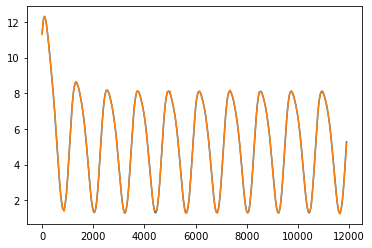

In [40]:
plt.plot(sol2.y[1][100:])
plt.plot(pop_new2[1])

In [34]:
dpop_diff3 = []
pop_data3 = sol3.y + np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data3 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data3 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
for i, x in enumerate(pop_data3):
    A = matlab.double(list(x))
    data_test = eng.TVRegDiff(A,20,1e-2, [], 'small', 1e-6, dt*0.01, 1, 1)
    dpop_diff3.append(data_test[1:])
dpop_diff3 = np.reshape(dpop_diff3, (dpop1.shape[0], dpop1.shape[1]))
dpop_diff3 *= 0.01

pop_new3 = []
for i in range(2):
    tmp = (np.cumsum(dpop_diff3[i])*dt)
    tmp += np.mean(pop_data3[i]) - np.mean(tmp) 
    pop_new3.append(tmp[100:])
pop_new3 = np.reshape(np.array(pop_new3), (pop_data3.shape[0], pop_data3.shape[1]-100))

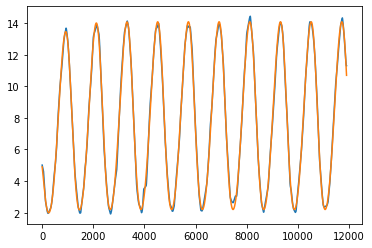

In [36]:
plt.plot(pop_new3[0])
plt.plot(sol3.y[0][100:])

In [29]:
dpop_diff4 = []
pop_data4 = sol4.y + np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data4 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data4 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
for i, x in enumerate(pop_data4):
    A = matlab.double(list(x))
    data_test = eng.TVRegDiff(A,20,0.1, [], 'small', 1e-6, dt*0.01, 1, 1)
    dpop_diff4.append(data_test[1:])
dpop_diff4 = np.reshape(dpop_diff4, (dpop1.shape[0], dpop1.shape[1]))
dpop_diff4 *= 0.01

pop_new4 = []
for i in range(2):
    tmp = (np.cumsum(dpop_diff4[i])*dt) 
    tmp += np.mean(pop_data4[i]) - np.mean(tmp) 
    pop_new4.append(tmp[100:])
pop_new4 = np.reshape(np.array(pop_new4), (pop_data4.shape[0], pop_data4.shape[1]-100))

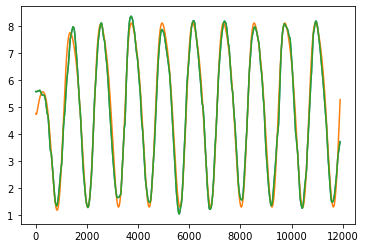

In [32]:
plt.plot(pop_new4[1])
plt.plot(sol4.y[1][100:])
plt.plot(pop_new4[1])

In [21]:
dpop_diff5 = []
pop_data5 = sol5.y + np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data5 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
pop_data5 += np.random.normal(0, 1, size=(sol1.y.shape[0],sol1.y.shape[1]))
for i, x in enumerate(pop_data5):
    A = matlab.double(list(x))
    data_test = eng.TVRegDiff(A,20,1e-2, [], 'small', 1e-6, dt*0.01, 1, 1)
    dpop_diff5.append(data_test[1:])
dpop_diff5 = np.reshape(dpop_diff5, (dpop1.shape[0], dpop1.shape[1]))
dpop_diff5 *= 0.01

pop_new5 = []
for i in range(2):
    tmp = (np.cumsum(dpop_diff5[i])*dt) 
    tmp += np.mean(pop_data5[i]) - np.mean(tmp) 
    pop_new5.append(tmp[100:])
pop_new5 = np.reshape(np.array(pop_new5), (pop_data5.shape[0], pop_data5.shape[1]-100))

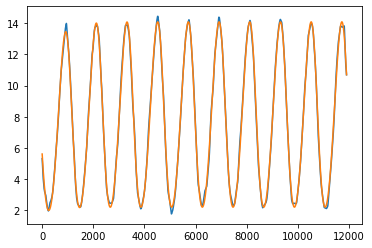

In [23]:
plt.plot(pop_new5[0])
plt.plot(sol5.y[0][100:])


In [42]:
pop_data = np.hstack([pop_new1, pop_new2, pop_new3, pop_new4, pop_new5])
dpop_data = np.hstack([dpop_diff1[:,100:], dpop_diff2[:,100:],dpop_diff3[:,100:], dpop_diff4[:,100:], dpop_diff5[:,100:]])

In [21]:
# pop_data = np.hstack([pop_new1, pop_new2])
# dpop_data = np.hstack([dpop_diff1[:,100:], dpop_diff2[:,100:]])

In [ ]:
plt.plot(dpop_)

In [57]:
pop_data = np.hstack([pop_data1, pop_data2, pop_data3, pop_data4, pop_data5])
# dpop_data = np.hstack([dpop_diff1[:,100:], dpop_diff2[:,100:],dpop_diff3[:,100:], dpop_diff4[:,100:], dpop_diff5[:,100:]])

In [58]:
dpop1 = ut.time_different(dt,dsol1, pop_data1)
dpop2 = ut.time_different(dt,dsol2, pop_data2)
dpop3 = ut.time_different(dt,dsol3, pop_data3)
dpop4 = ut.time_different(dt,dsol4, pop_data4)
dpop5 = ut.time_different(dt,dsol5, pop_data5)
dpop_data = np.hstack([dpop1, dpop2, dpop3,dpop4, dpop5])
# dpop_data_new = np.hstack([dpop1, dpop2, dpop3,dpop4, dpop5])
# pop_data_new = np.hstack([pop_data1, pop_data2, pop_data3, pop_data4, pop_data5])

In [205]:
# dpop_diff_new1 = ut.time_different(dt,dpop_diff1, pop_new1)
# dpop_diff_new2 = ut.time_different(dt,dpop_diff2, pop_new2)
# dpop_diff_new3 = ut.time_different(dt,dpop_diff3, pop_new3)
# dpop_diff_new4 = ut.time_different(dt,dpop_diff4, pop_new4)
# dpop_diff_new5 = ut.time_different(dt,dpop_diff5, pop_new5)
# dpop_data_new = np.hstack([dpop_diff_new1, dpop_diff_new2, dpop_diff_new3, dpop_diff_new4, dpop_diff_new5])

In [59]:
tspan_ = []
for i in range(5):
    tspan_.extend(tspan.flatten())

In [60]:
A_array = [ 0.2, 0.5, 0.8, 1]
k_array = [0.2, 0.5, 0.8, 1]
p_array = [0, 6, 12, 18]

u_matrix = np.array([], dtype=np.float).reshape(len(tspan_), 0)
lab_name = []
for i in k_array:
    for j in A_array:
        for k in p_array:
            tmp = 2*np.pi*((np.array(tspan_) - k) % 24)/24
            k_ = i*(1+j*np.cos(tmp)).reshape(-1, 1)
            u_matrix  = np.hstack([u_matrix, k_.reshape(-1,1)])
            lab_name.append("p:{0} A:{1} k:{2}".format(str(k), str(j), str(i)))

In [61]:
pop_data.shape, u_matrix.shape

((2, 60000), (60000, 64))

In [62]:
one_vec = np.ones((len(tspan_),1))
theta_inital = np.hstack([one_vec, pop_data[0].reshape(-1,1), pop_data[1].reshape(-1,1)])
theta_ = np.hstack([theta_inital, u_matrix*pop_data[0].reshape(-1,1), u_matrix*pop_data[1].reshape(-1,1)])

In [164]:
# Xi2 = ut.sparsifyDynamics(theta_, dpop_data.T, 0.02)

In [169]:
# indL,  = np.where(abs(Xi2[:,0]) > 0.01)
# indS, = np.where(abs(Xi2[:,1]) > 0.01)

In [63]:
clf = linear_model.Lasso(alpha=1e-3, fit_intercept=False, max_iter=1e5)
clf.fit(theta_,dpop_data.T)
Xi = clf.coef_

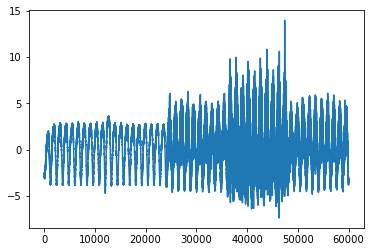

In [81]:
plt.plot(theta_.dot(Xi.T)[:,0])

In [82]:
indL,  = np.where(abs(Xi[0]) > 0.05)
indS, = np.where(abs(Xi[1]) > 0.05)

In [83]:
print(Xi[0,indL])
print(indL)

[-2.72459647 -0.18607464  0.17329109  0.06683451  0.14723251  0.16199608]
[  0  64  65  66 125 129]


In [84]:
print('[L] * K')
# print(lab_name[49-3])
print(lab_name[64-3])
print(lab_name[65-3])
print(lab_name[66-3])
print('[S] * K')
# print(lab_name[107-67])
# print(lab_name[108-67])
print(lab_name[125-67])
# print(lab_name[112-67])
# print(lab_name[127-67])
# print(lab_name[128-67])
print(lab_name[129-67])
# print(lab_name[130-67])

[L] * K
p:6 A:1 k:1
p:12 A:1 k:1
p:18 A:1 k:1
[S] * K
p:12 A:0.8 k:1
p:12 A:1 k:1


In [85]:
print(Xi[1,indS])
print(indS)

[ 2.63987098 -0.13684083 -0.0913629  -0.05610671 -0.06621027 -0.13041599
  0.09747539 -0.07831802 -0.05570901  0.11271664]
[  0  33  45  48  49  64 127 128 129 130]


In [87]:
print('[L] * K')
print(lab_name[33-3])
print(lab_name[64-3])
print('[S] * K')
print(lab_name[128-67])
print(lab_name[129-67])

[L] * K
p:12 A:1 k:0.5
p:6 A:1 k:1
[S] * K
p:6 A:1 k:1
p:12 A:1 k:1


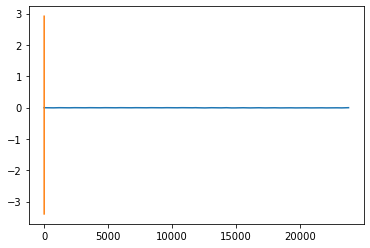

In [55]:
plt.plot(theta_.dot(Xi[1]))
plt.plot(dsol1[1])